# Modeling human movement

## Temporal features

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pointing_model import PointingModel, features, utils, learning, plotting
import matplotlib.pyplot as plt
import pandas as pd

The ```PointingModel``` class provides utilities for loading, analysing and modeling the data. 

In [3]:
pointing = PointingModel({
    # configure load parameters
    'load_default_fast': True,
    'load': {
        'loading_path': './data_export',
        # 'loading_path': './data',
    },
    # configure normalization
    'normalize': {
        'take_only_final': False
    },
    # load dynamic/temporal features
    'dynamic': {
        'load': True
    },
})

Here we define some default values for the ongoing analyis. The ```feats``` variable contains a list of the desired features.

In [4]:
target_fields = utils.target_fields()
body_fields = utils.all_body_fields()
feats = utils.temporal_features()

exclude = utils.exclude_temporal_features()

## Feature analysis

Plotting the correlation matrix of the base body values with the target labels. Here we can see correlations between a markerset position and a target position, which gives clues about how to engineer features.

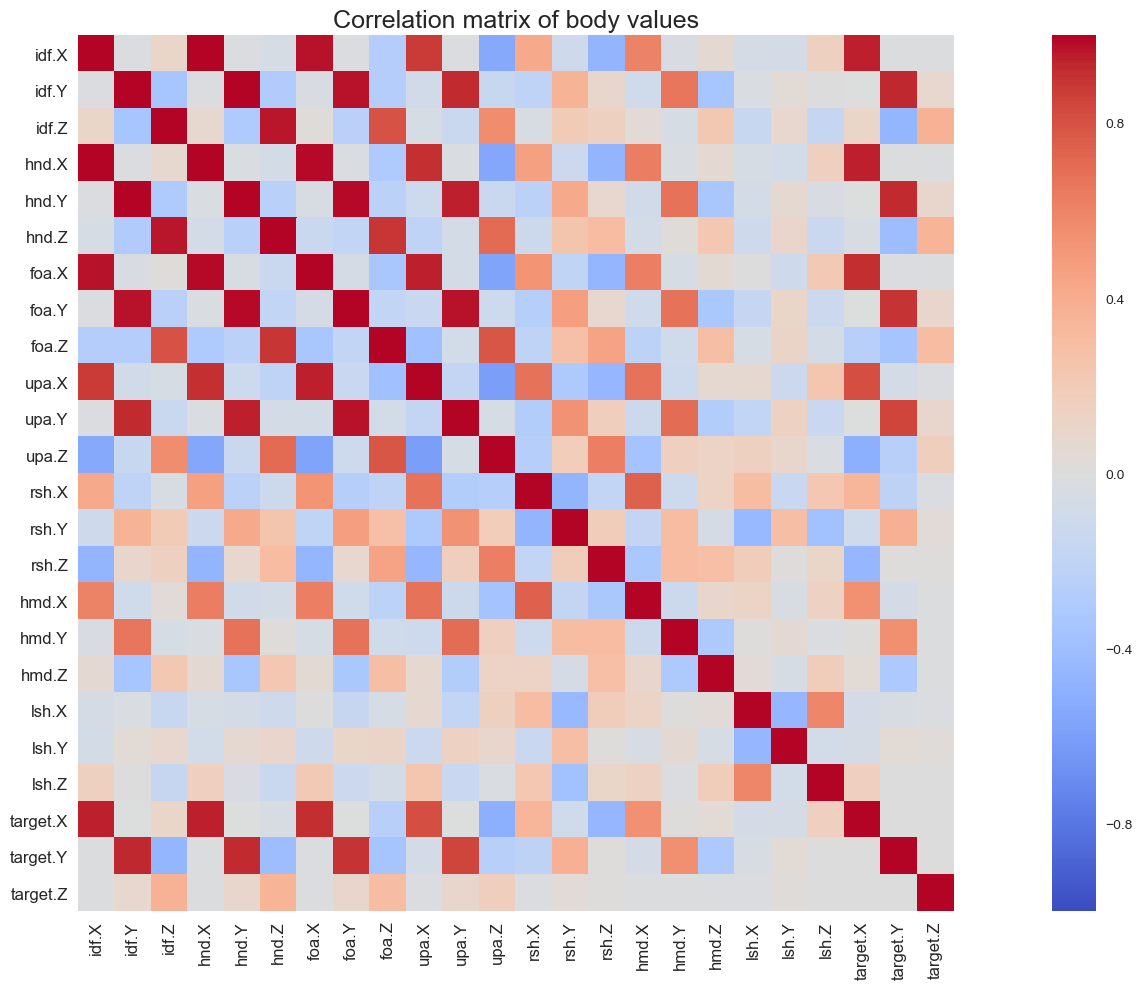

In [5]:
pointing.plot_correlation_matrix(base_fields=body_fields, force=True, additional_fields=target_fields)

Plotting the correlation matrix between the selected features and the target labels.

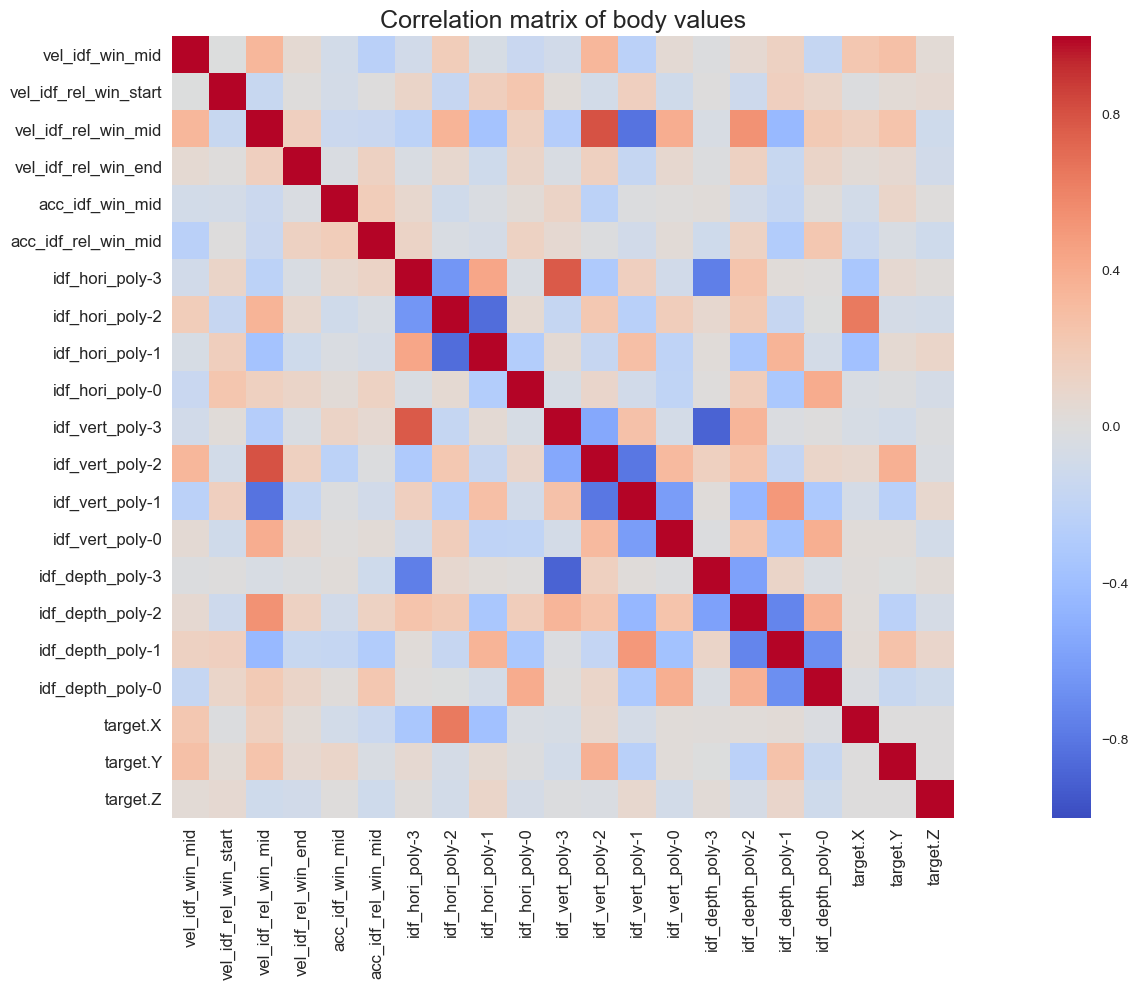

In [6]:
pointing.plot_correlation_matrix(base_fields=feats, force=True, additional_fields=target_fields, exclude_features=exclude)

Plotting the $\chi^2$-test between the selected features and the target labels.

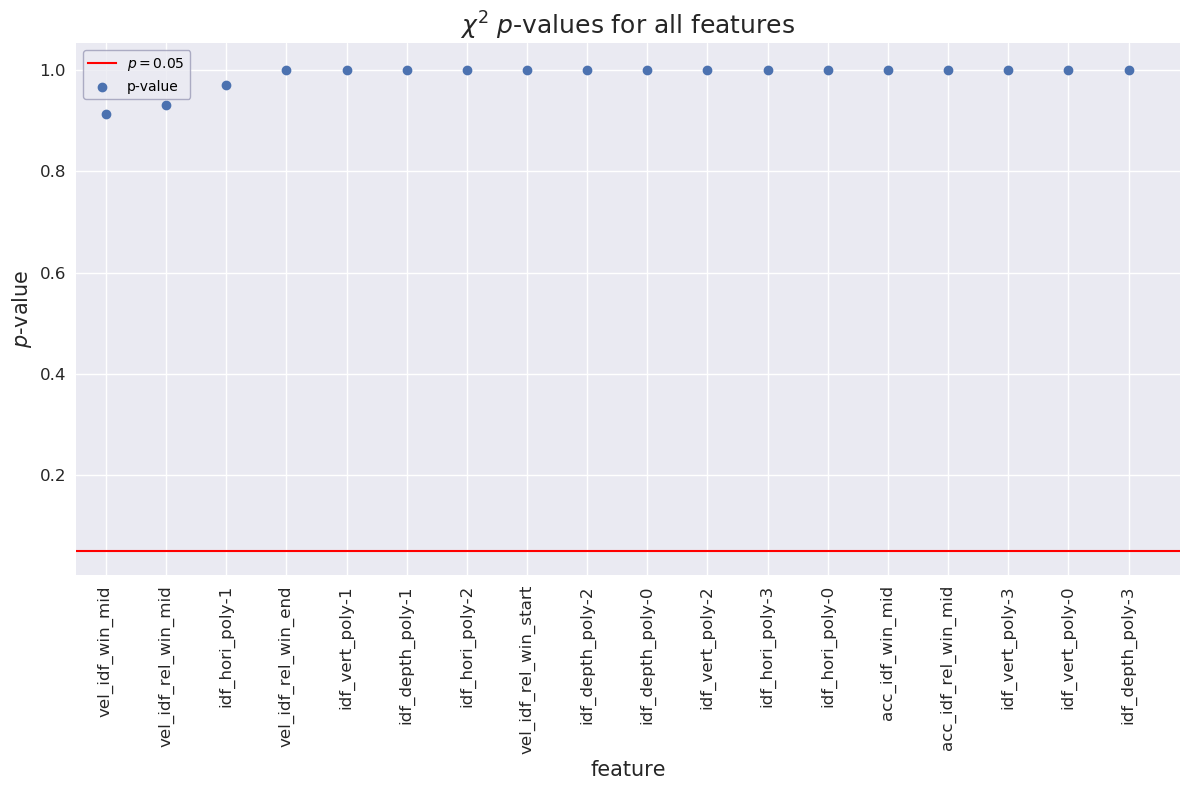

<Figure size 432x288 with 0 Axes>

In [7]:
pointing.plot_selectKBest_chi2(fields=feats, force=True, exclude_features=exclude)

Plotting the mutual information between the selected features and the target labels.

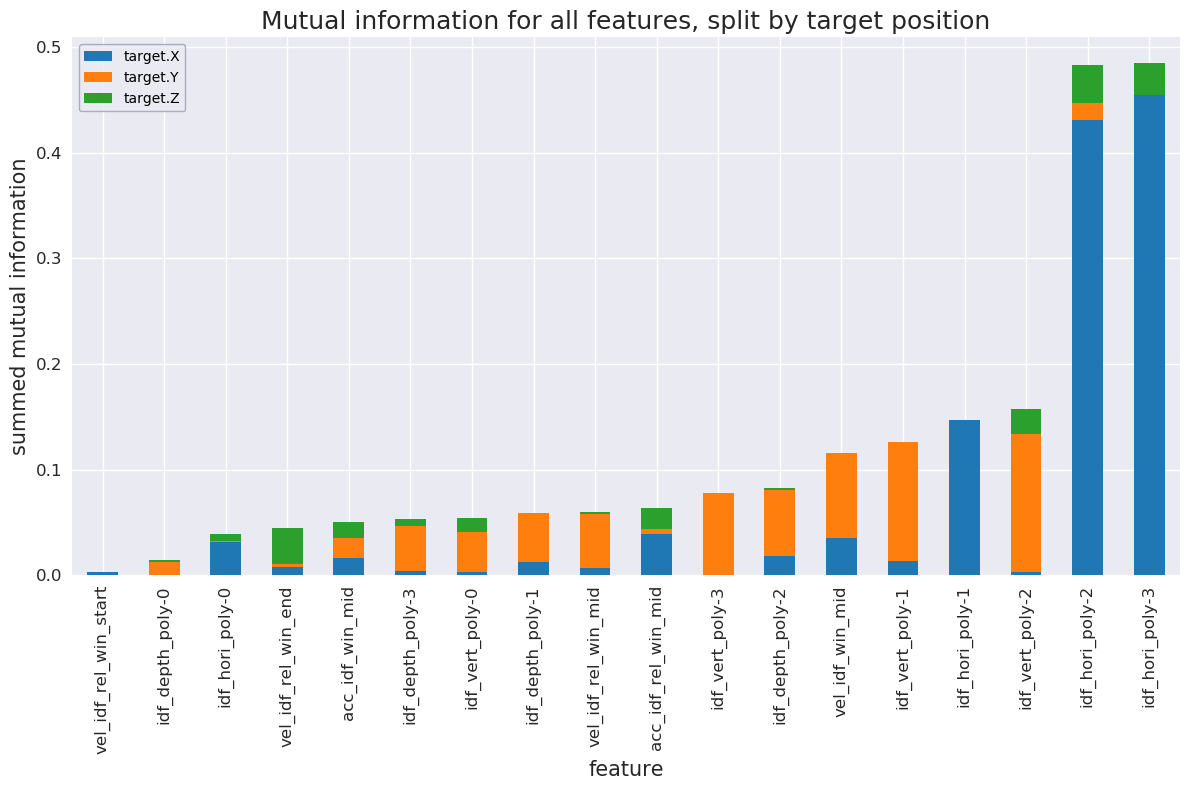

<Figure size 432x288 with 0 Axes>

In [8]:
pointing.plot_selectKBest_mutual_information(fields=feats, force=True, exclude_features=exclude)

Plotting feature importance, using ```sklearn.ensemple.ExtraTreesClassifier``` for computing the importance measure.

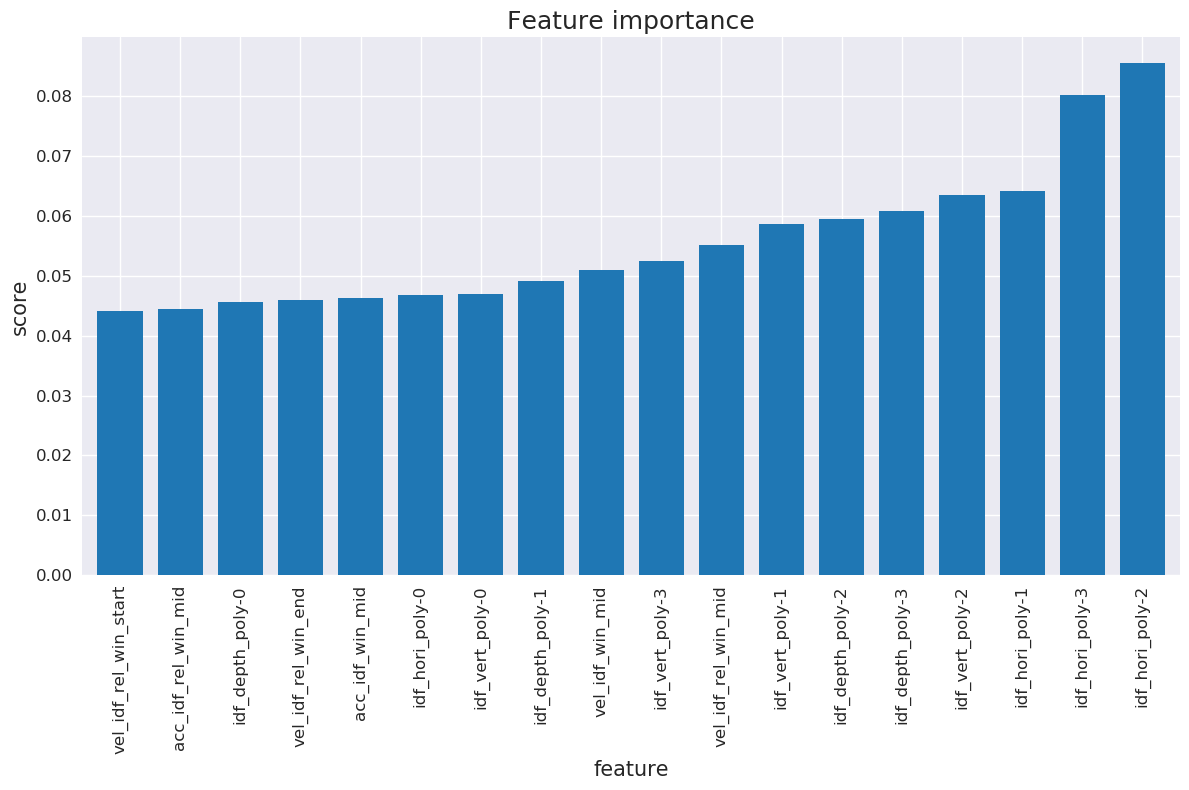

<Figure size 432x288 with 0 Axes>

In [9]:
pointing.plot_extratrees(fields=feats, force=True, exclude_features=exclude)

## Machine learning

### Pipeline
We first conduct a gridsearch, in order to find the best parameters for a model. Then these best parameters are used to train a model on 80% of the dataset. 20% of the data is then used to compute the test score, which we can compare against a 5-fold cross validation score obtained on first mentioned 80% of data.

### Classification

We use three different classification algorithms for comparison: Naive Bayes, SVM and random forest.

In [10]:
c_models = pointing.classification_models
c_models

[pointing_model.learning.models.svm.SupportVectorMachine,
 pointing_model.learning.models.random_forest.RandomForest,
 pointing_model.learning.models.naive_bayes.NaiveBayes]

We first conduct a gridsearch on the models to find the best performing parameters.

In [11]:
c_search = {}
for cm in c_models:
    m, p = pointing.machine_learning_gridsearch(
        cm, features=feats, preprocess_kwargs={'exclude_features': exclude}
    )
    c_search[m.name] = (cm, p)


****

Using:SVM
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 10000, 'kernel': 'linear'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       1.00      1.00      1.00        11
(-1.0, 0.49, 2.5)       0.89      0.94      0.91        17
(-1.0, 0.49, 3.5)       0.91      0.77      0.83        13
(-1.0, 1.49, 1.5)       1.00      0.91      0.95        11
(-1.0, 1.49, 2.5)       0.67      0.75      0.71         8
(-1.0, 1.49, 3.5)       0.79      0.85      0.81        13
(-1.0, 2.49, 1.5)       0.67      0.83      0.74        12
(-1.0, 2.49, 2.5)       0.70      0.82      0.76        17
(-1.0, 2.49, 3.5)       1.00      0.65      0.79        17
 (0.0, 0.49, 1.5)       0.92      0.92      0.92        13
 (0.0, 0.49, 2.5)       0.76      0.81      0.7

The best parameters are stored in a dictionary for later use in training the models.

In [12]:
c_search = {'SVM': (learning.SupportVectorMachine,
  {'C': 10000, 'kernel': 'linear'}),
 'Random Forest': (learning.RandomForest,
  {'criterion': 'entropy',
   'max_depth': 10,
   'max_features': 'auto',
   'n_estimators': 175,
   'random_state': 0}),
 'Naive Bayes': (learning.NaiveBayes,
  {'var_smoothing': 1e-09})}
c_search

{'SVM': (pointing_model.learning.models.svm.SupportVectorMachine,
  {'C': 10000, 'kernel': 'linear'}),
 'Random Forest': (pointing_model.learning.models.random_forest.RandomForest,
  {'criterion': 'entropy',
   'max_depth': 10,
   'max_features': 'auto',
   'n_estimators': 175,
   'random_state': 0}),
 'Naive Bayes': (pointing_model.learning.models.naive_bayes.NaiveBayes,
  {'var_smoothing': 1e-09})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.


****

Using:SVM
5-fold cross validation score: 0.5007498729028977
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.64      0.64      0.64        11
(-1.0, 0.49, 2.5)       0.50      0.65      0.56        17
(-1.0, 0.49, 3.5)       0.56      0.38      0.45        13
(-1.0, 1.49, 1.5)       0.75      0.82      0.78        11
(-1.0, 1.49, 2.5)       0.27      0.38      0.32         8
(-1.0, 1.49, 3.5)       0.50      0.38      0.43        13
(-1.0, 2.49, 1.5)       0.46      0.50      0.48        12
(-1.0, 2.49, 2.5)       0.39      0.41      0.40        17
(-1.0, 2.49, 3.5)       0.36      0.24      0.29        17
 (0.0, 0.49, 1.5)       0.71      0.92      0.80        13
 (0.0, 0.49, 2.5)       0.44      0.25      0.32        16
 (0.0, 0.49, 3.5)       0.50      0.46      0.48        13
 (0.0, 1.49, 1.5)       0.43      0.25      0.32        12
 (0.0, 1.49, 2.5)       0.14      0.38      0.21         8
 (0.0, 1.49, 3.

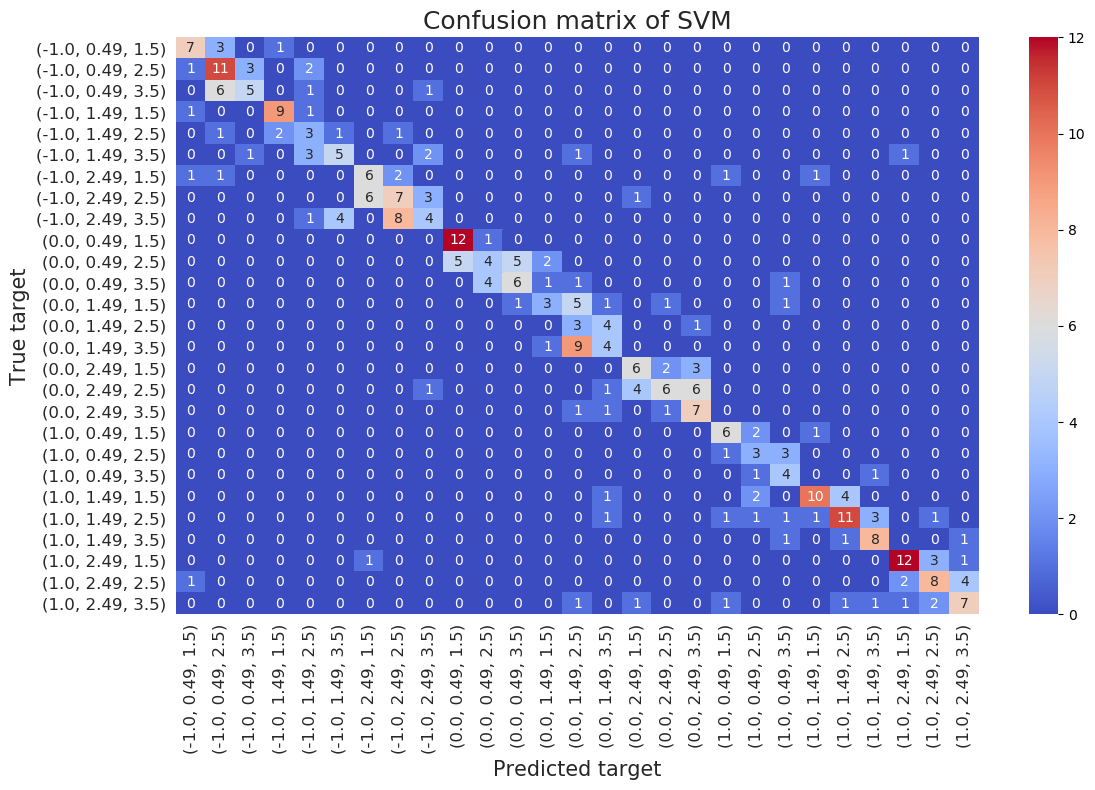

-----------------------

****

Using:Random Forest
5-fold cross validation score: 0.33764107778342656
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.41      0.64      0.50        11
(-1.0, 0.49, 2.5)       0.33      0.18      0.23        17
(-1.0, 0.49, 3.5)       0.42      0.38      0.40        13
(-1.0, 1.49, 1.5)       0.33      0.45      0.38        11
(-1.0, 1.49, 2.5)       0.20      0.38      0.26         8
(-1.0, 1.49, 3.5)       0.20      0.23      0.21        13
(-1.0, 2.49, 1.5)       0.40      0.50      0.44        12
(-1.0, 2.49, 2.5)       0.42      0.29      0.34        17
(-1.0, 2.49, 3.5)       0.29      0.24      0.26        17
 (0.0, 0.49, 1.5)       0.58      0.85      0.69        13
 (0.0, 0.49, 2.5)       0.62      0.31      0.42        16
 (0.0, 0.49, 3.5)       0.21      0.23      0.22        13
 (0.0, 1.49, 1.5)       0.40      0.50      0.44        12
 (0.0, 1.49, 2.5)       0.08      0.12 

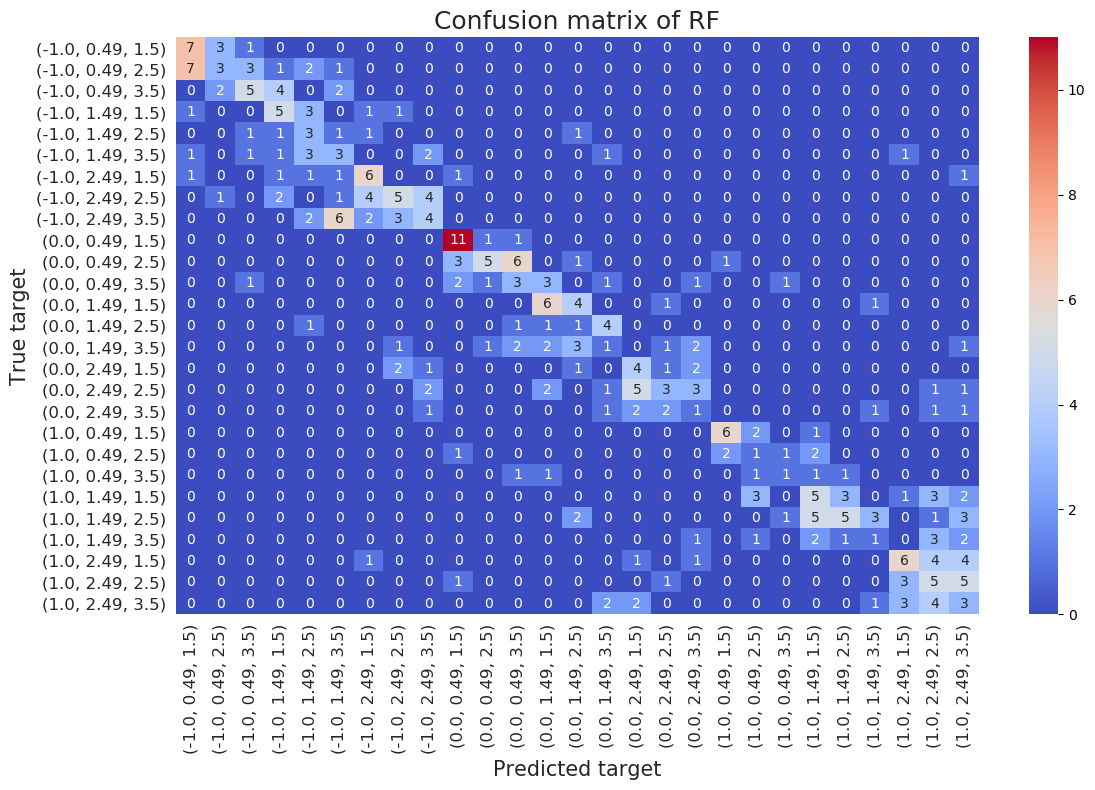

-----------------------

****

Using:Naive Bayes
5-fold cross validation score: 0.18519572953736657
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.32      0.55      0.40        11
(-1.0, 0.49, 2.5)       0.00      0.00      0.00        17
(-1.0, 0.49, 3.5)       0.08      0.08      0.08        13
(-1.0, 1.49, 1.5)       0.21      0.27      0.24        11
(-1.0, 1.49, 2.5)       0.19      0.50      0.28         8
(-1.0, 1.49, 3.5)       0.00      0.00      0.00        13
(-1.0, 2.49, 1.5)       0.43      0.25      0.32        12
(-1.0, 2.49, 2.5)       0.75      0.18      0.29        17
(-1.0, 2.49, 3.5)       0.08      0.24      0.12        17
 (0.0, 0.49, 1.5)       0.27      0.62      0.37        13
 (0.0, 0.49, 2.5)       0.14      0.12      0.13        16
 (0.0, 0.49, 3.5)       0.00      0.00      0.00        13
 (0.0, 1.49, 1.5)       0.27      0.25      0.26        12
 (0.0, 1.49, 2.5)       0.10      0.12   

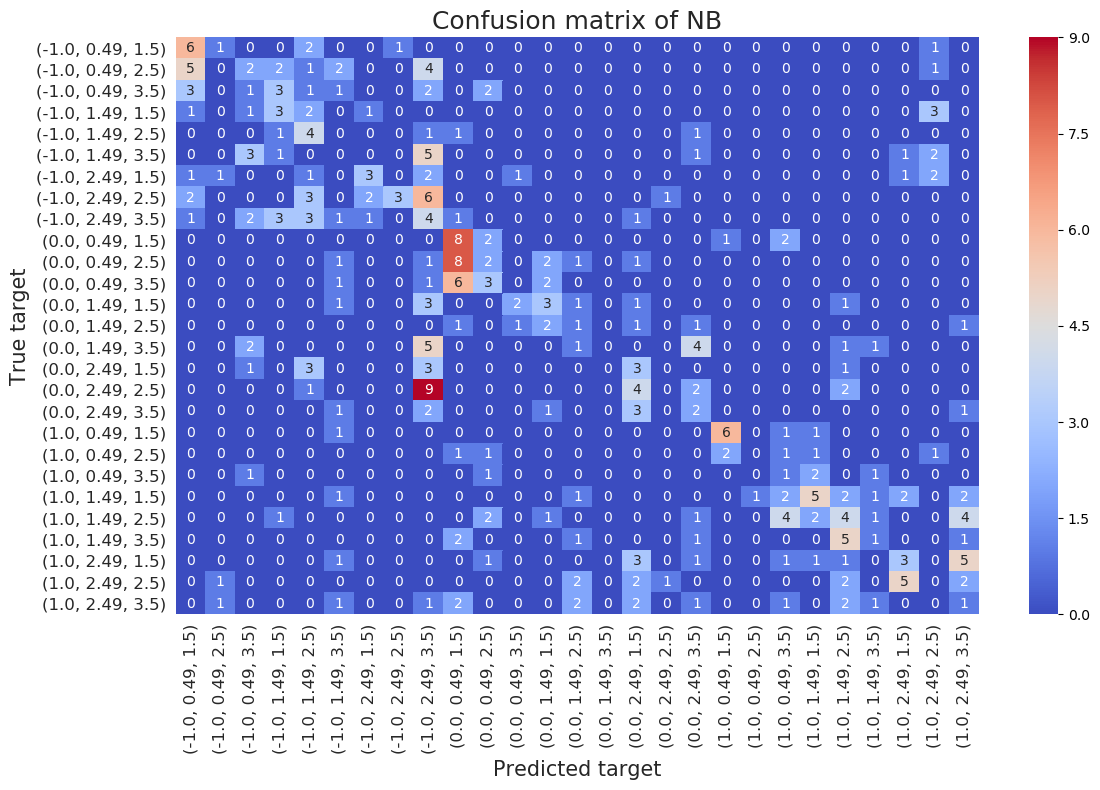

-----------------------


In [13]:
c_scores = {}
for k in c_search:
    cm, p = c_search[k]
    m, s = pointing.machine_learning_kfold(
        cm, model_kwargs=p, cleanup=True, save=False, features=feats,
        preprocess_kwargs={'exclude_features': exclude}
    )
    c_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [14]:
pd.DataFrame.from_dict(c_scores).T

,cross-validation,accuracy,f1-score
SVM,0.500750,0.504274,0.497252
Random Forest,0.337641,0.310541,0.303116
Naive Bayes,0.185196,0.182336,0.171827


### Regression

Also for regression we compare three different models: Linear Regression, SVM and random forest.

In [15]:
 r_models = pointing.regression_models
 r_models

[pointing_model.learning.models.svm.SupportVectorMachineRegression,
 pointing_model.learning.models.random_forest.RandomForestRegression,
 pointing_model.learning.models.linear_regression.LinearRegression]

We first conduct a gridsearch on the models to find the best performing parameters.

In [16]:
r_search = {'Linear Regression': (learning.LinearRegression, {})}
for rm in r_models:
    m, p = pointing.machine_learning_gridsearch(
        rm, features=feats, preprocess_kwargs={'exclude_features': exclude}
    )
    r_search[m.name] = (rm, p)


****

Using:SVM
# Tuning hyper-parameters
Best parameters set found on development set:
{'estimator__C': 10.0, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.13  0.62  1.90  0.57
                    2.5       -0.89  0.79  2.38  0.50
                    3.5       -0.76  0.98  2.40  1.26
          1.49      1.5       -1.28  1.60  2.09  0.73
                    2.5       -0.80  1.54  2.32  0.50
                    3.5       -0.69  1.55  2.66  0.94
          2.49      1.5       -0.78  2.16  1.98  0.80
                    2.5       -0.79  2.29  2.28  0.57
                    3.5       -0.54  2.03  2.56  1.21
 0.0      0.49  

AttributeError: 'MultiOutputRegressor' object has no attribute 'best_params_'

The best parameters are stored in a dictionary for later use in training the models.

In [17]:
r_search

{'Linear Regression': (pointing_model.learning.models.linear_regression.LinearRegression,
  {}),
 'SVM': (pointing_model.learning.models.svm.SupportVectorMachineRegression,
  {'estimator__C': 10.0,
   'estimator__gamma': 0.01,
   'estimator__kernel': 'rbf'}),
 'Random Forest Regression': (pointing_model.learning.models.random_forest.RandomForestRegression,
  {'criterion': 'mse',
   'max_depth': 14,
   'max_features': 'auto',
   'n_estimators': 175,
   'random_state': 0})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.


****

Using:Linear Regression
5-fold cross validation score: 1.048257638940602

Description of distances:
count    27.000000
mean      1.840282
std       5.531209
min       0.167863
25%       0.517635
50%       0.846436
75%       1.033940
max      29.466153
Name: (dist, real_mean), dtype: float64



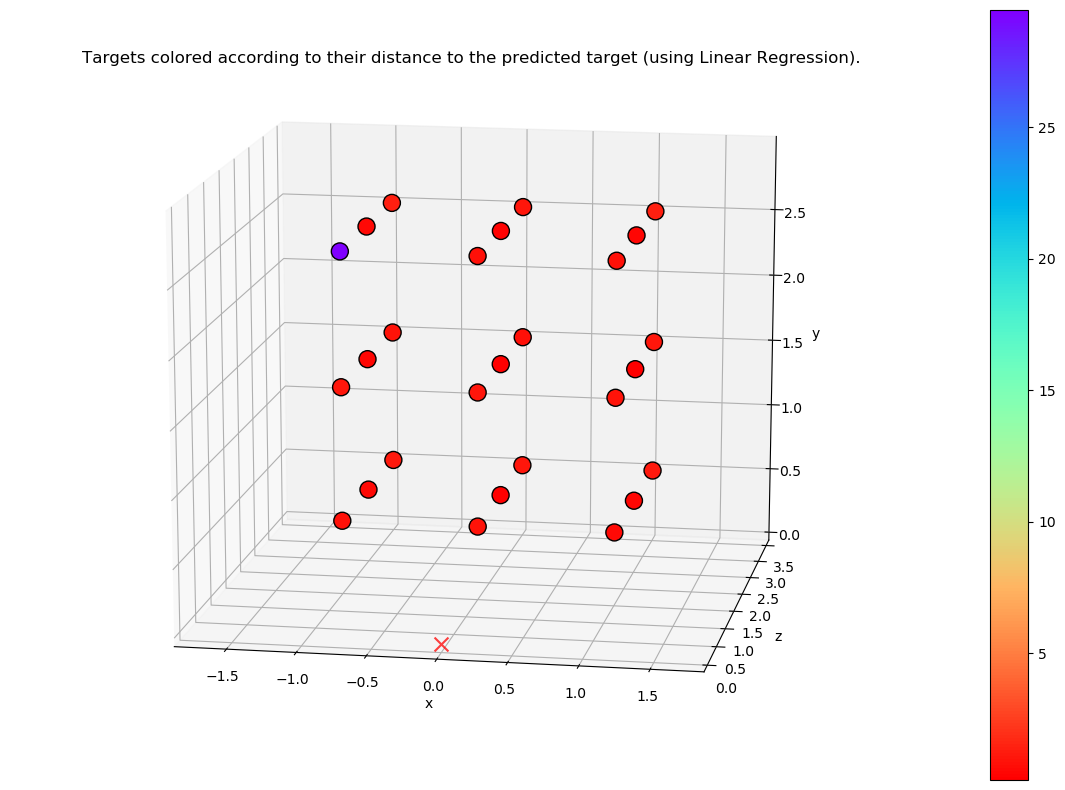

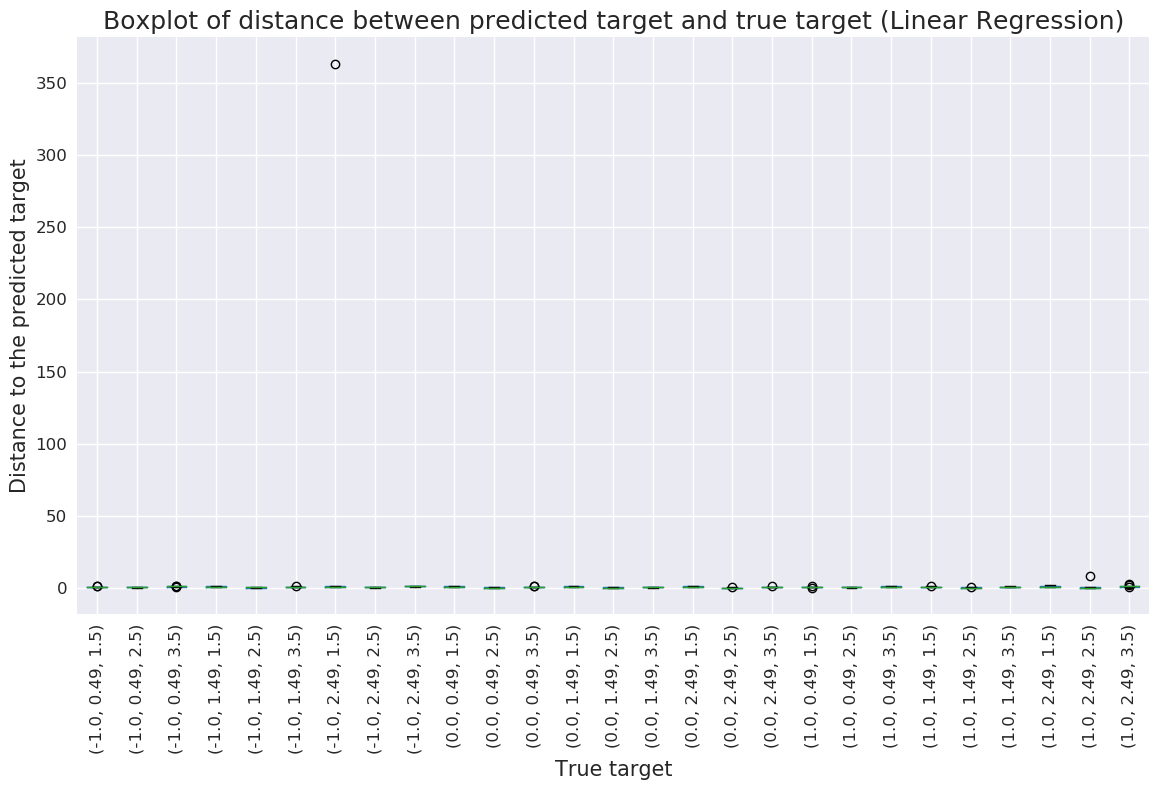

-----------------------
distances:
                               pred                 dist
                                  x      y      z       
(true, x) (true, y) (true, z)                           
-1.0      0.49      1.5       -0.99   0.90   2.20   0.97
                    2.5       -0.77   1.00   2.50   0.69
                    3.5       -0.62   1.06   2.53   1.25
          1.49      1.5       -1.31   1.70   2.41   1.10
                    2.5       -0.63   1.49   2.19   0.60
                    3.5       -0.53   1.55   2.70   1.08
          2.49      1.5       -5.99  22.50 -19.55  31.34
                    2.5       -0.62   2.13   2.30   0.74
                    3.5       -0.44   1.88   2.43   1.41
 0.0      0.49      1.5       -0.04   0.23   2.40   1.09
                    2.5       -0.00   0.72   2.58   0.50
                    3.5       -0.01   0.95   2.55   1.08
          1.49      1.5       -0.09   1.37   2.52   1.12
                    2.5       -0.14   1.43   2.58   0

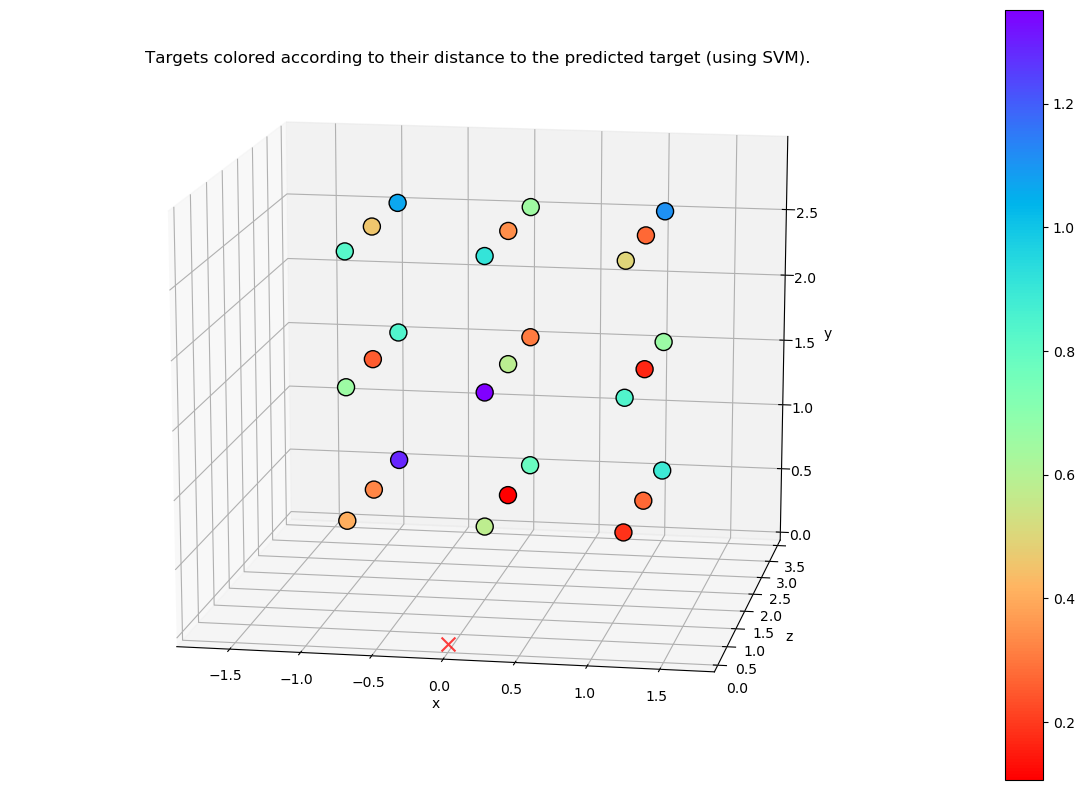

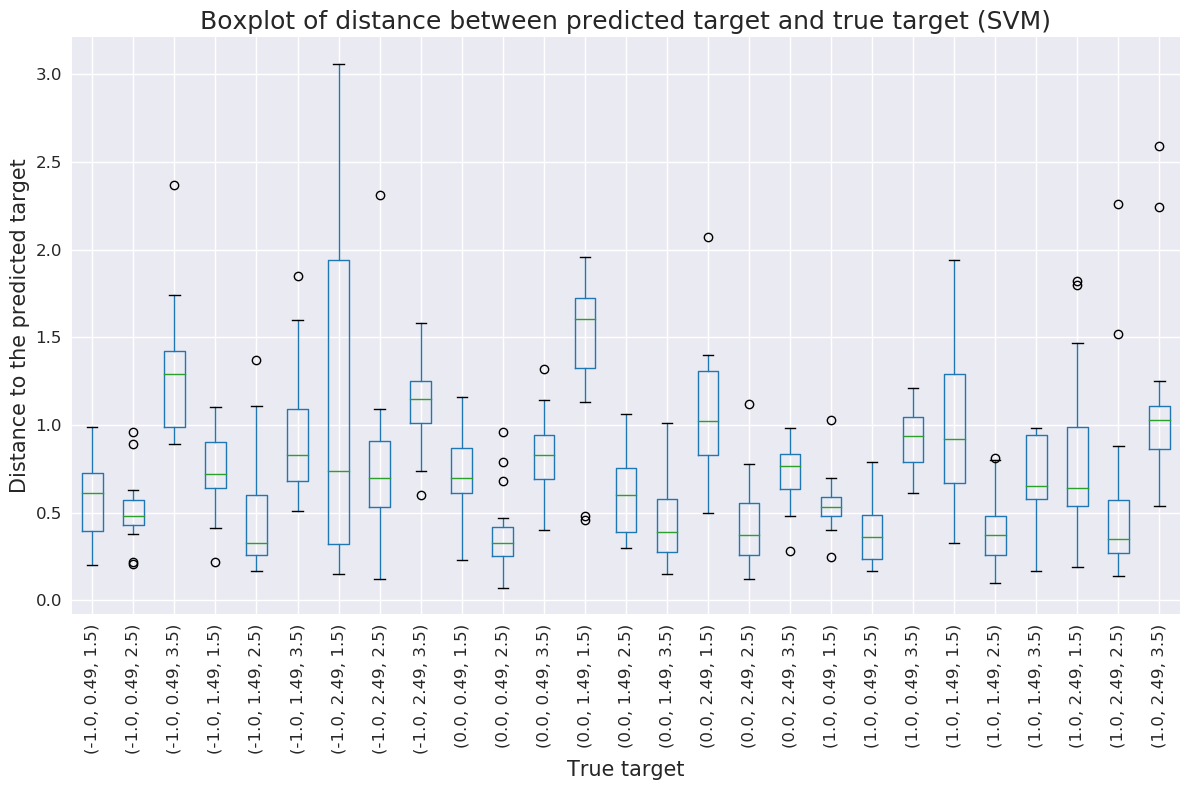

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.13  0.54  1.88  0.58
                    2.5       -0.90  0.72  2.29  0.51
                    3.5       -0.75  0.97  2.33  1.31
          1.49      1.5       -1.31  1.55  2.08  0.74
                    2.5       -0.82  1.49  2.32  0.53
                    3.5       -0.67  1.58  2.73  0.94
          2.49      1.5       -0.63  1.98  2.03  1.13
                    2.5       -0.82  2.34  2.11  0.75
                    3.5       -0.59  2.07  2.61  1.13
 0.0      0.49      1.5       -0.00  0.17  1.98  0.70
                    2.5        0.00  0.44  2.41  0.39
                    3.5        0.00  0.79  2.78  0.84
          1.49      1.5        0.04  1.40  2.85  1.43
                    2.5       -0.00  1.39  3.08  0.62
                    3.5        0.01  1.51  3.19

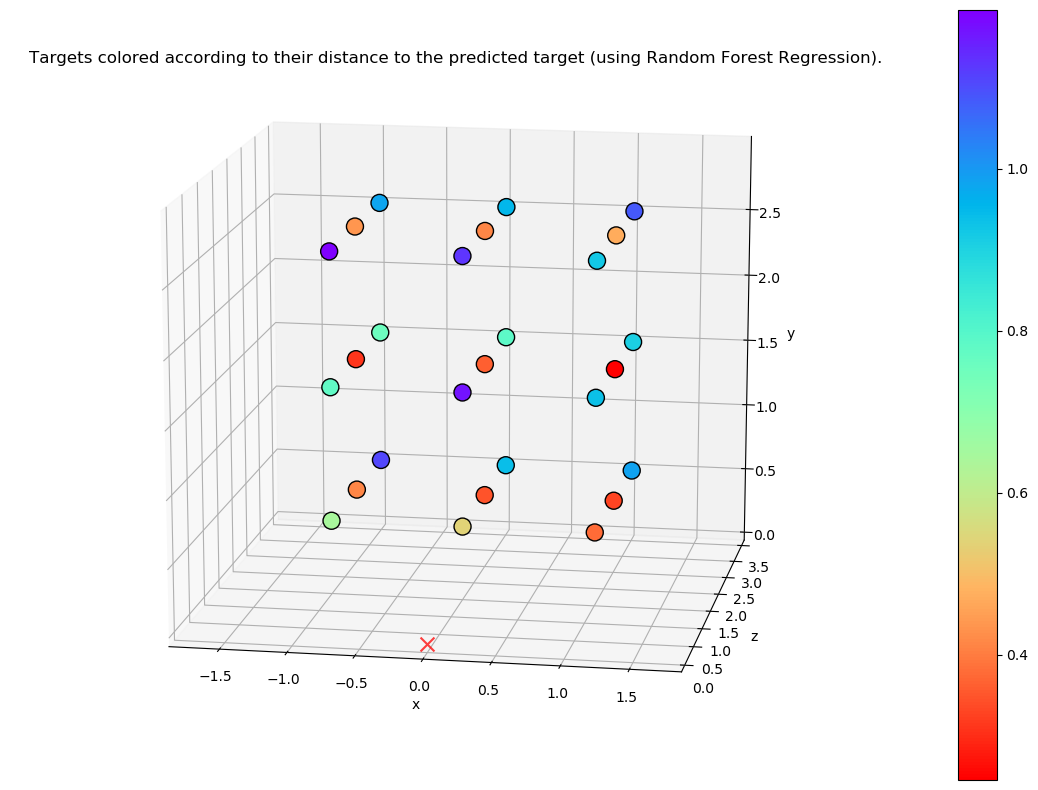

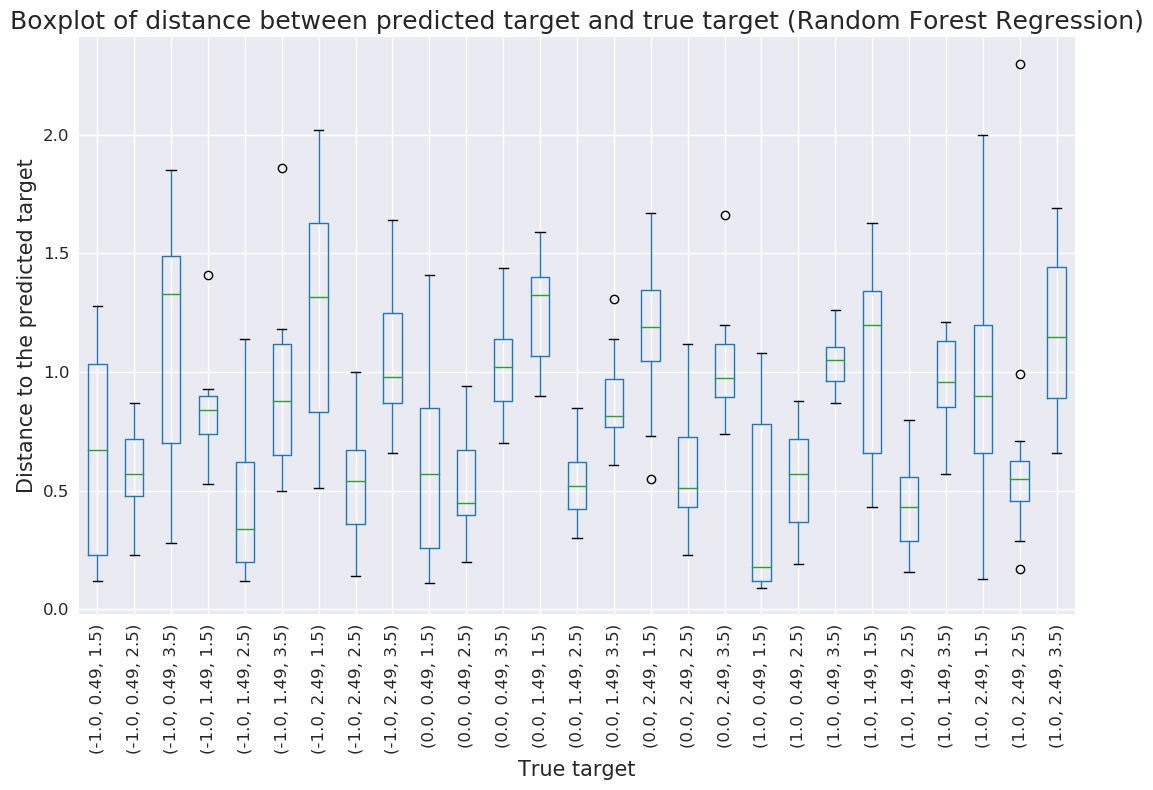

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -0.81  0.68  2.08  0.67
                    2.5       -0.86  0.87  2.44  0.56
                    3.5       -0.90  1.08  2.57  1.17
          1.49      1.5       -0.94  1.52  2.28  0.84
                    2.5       -0.70  1.51  2.57  0.47
                    3.5       -0.68  1.43  2.81  0.90
          2.49      1.5       -0.66  1.77  2.39  1.28
                    2.5       -0.88  2.07  2.45  0.56
                    3.5       -0.80  1.96  2.70  1.04
 0.0      0.49      1.5        0.15  0.61  2.01  0.59
                    2.5        0.17  0.80  2.52  0.50
                    3.5        0.13  1.01  2.73  1.02
          1.49      1.5        0.13  1.62  2.66  1.26
                    2.5       -0.04  1.45  2.86  0.53
                    3.5        0.18  1.63  2.75

In [18]:
r_scores = {}
for k in r_search:
    cm, p = r_search[k]
    p = {i.replace('estimator__', ''): p[i] for i in p}
    m, s = pointing.machine_learning_kfold(
        cm, model_kwargs=p, cleanup=True, features=feats,
        analyze_distances=plotting.analyze_distances, save=False,
        preprocess_kwargs={'exclude_features': exclude}
    )
    r_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [19]:
pd.DataFrame.from_dict(r_scores).T

,cross-validation,mean_distance,rmse
Linear Regression,1.048258,1.840282,11.208390
SVM,0.539718,0.616998,0.520951
Random Forest Regression,0.528829,0.723723,0.532559
